In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
from laos_gggi.emdat_processing import process_emdat
from laos_gggi.plotting import plot_descriptive, _plot_single_kde
from laos_gggi.const_vars import EM_DAT_COL_DICT, DISASTERS_FOUND, INTENSITY_COLS, EM_DAT_COL_DICT
from laos_gggi.summary_stats import descriptive_stats_function

# 0. Importing data

In [3]:
data = process_emdat()[0]

intensity_df = data["df_inten"]
probability_df = data["df_prob"]
em_dat_raw = data["df_raw"]
probability_df_filtered = data["df_prob_filtered"] 
intensity_df_filtered = data["df_inten_filtered"]
em_dat_raw_filtered = data["df_raw_filtered"]   

# 1. Helper functions

In [4]:
#Aggregated plotting function
def subplots_function( df, var_list, index, aggregation_funct, title , graph_rows =2, figure_size=  (20, 18) ,subplot_title_fontsize= 14):
    fig, axs = plt.subplots(graph_rows,2, figsize= figure_size)

    for x in var_list:
        a = math.floor(var_list.index(x)/2)
        b = var_list.index(x)%2 
        axs[a,b].plot(df.pivot_table(values= x,  index = index, aggfunc= aggregation_funct)[x])
        axs[a,b].set_title(x, fontsize = subplot_title_fontsize)

    if ((len(var_list) % 2) != 0):
        axs[graph_rows-1,1].set_axis_off()
        
    plt.suptitle(title, fontsize = subplot_title_fontsize+10 )
    fig.tight_layout()

In [5]:
Regions = ["Asia", "Europe", "Africa", "Oceania", "Americas"]

#Aggregated plotting function
def subplots_function_regions( df, var_list, index, aggregation_funct, title , graph_rows =2, figure_size=  (20, 18) ,subplot_title_fontsize= 14):
    fig, axs = plt.subplots(graph_rows,2, figsize= figure_size)

    for x in var_list:
        a = math.floor(var_list.index(x)/2)
        b = var_list.index(x)%2 
        for y in Regions:
            axs[a,b].plot( df.query(f'Region == "{y}"').pivot_table(values= x,  index = index, aggfunc= aggregation_funct), label = y)
            axs[a,b].set_title(x, fontsize = subplot_title_fontsize)
           # axs[a,b].legend()
        
    if ((len(var_list) % 2) != 0):
        axs[graph_rows-1,1].set_axis_off()
    fig.legend(Regions, loc='lower right', ncol=5, fontsize = 16)
    plt.suptitle(title, fontsize = subplot_title_fontsize+10 )
    fig.tight_layout(rect=[0, 0, 1, 0.95])

In [6]:
#Data Columns
intensity_cols = intensity_df.describe().columns.to_list()
probability_cols = probability_df.describe().columns.to_list()

# 2. Effects of the filters

For the analysis only the events that satisfy the next criteria were considered:
- Start_Year > 1970
- Total_Affected > 1000
- Deaths > 100
  
These criteria follow the ones used by López, Thomas and Troncoso (2015).

Additionally, we consider only the next type of disasters:
"Drought", "Earthquake", "Extreme temperature", "Flood", "Storm", "Volcanic activity", "Wildfire".

When appliying the filters, the number of events in Laos is reduced from 62 to 1


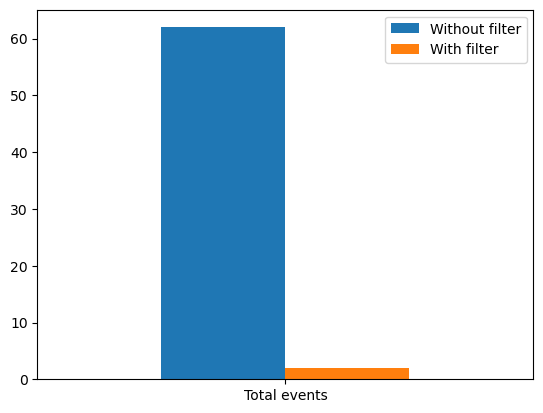

In [7]:
print("When appliying the filters, the number of events in Laos is reduced from " + str(em_dat_raw.query('ISO == "LAO"').shape[0] )+ " to " 
      + str(probability_df_filtered.loc["LAO"].shape[0]))
obs_effect = pd.DataFrame(columns=["Without filter", "With filter"])
obs_effect.loc["Total events"] = [em_dat_raw.query('ISO == "LAO"').shape[0], em_dat_raw_filtered.query('ISO == "LAO"').shape[0]]
obs_effect.plot(kind = "bar").set_xticklabels(labels = ["Total events"], rotation = 0);

Given the reduced number of events for Laos when the filters are applied, we will use different thresholds to analyze Laos.

We will limit the filters to:
- Start_Year > 1970
- Total_Affected > 1000
- Disasters:  "Drought", "Earthquake", "Extreme temperature", "Flood", "Storm", "Volcanic activity", "Wildfire"

When appliying the filters, the number of events in Laos is reduced from 62 to 33


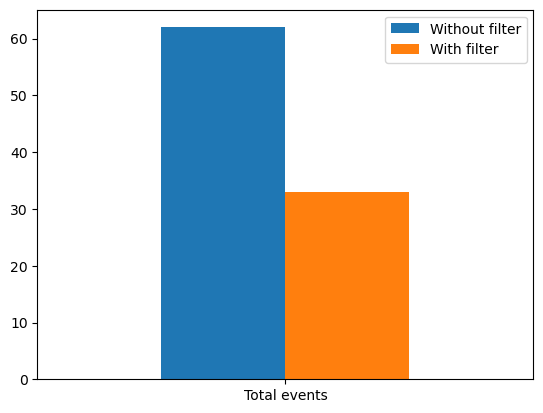

In [8]:
print("When appliying the filters, the number of events in Laos is reduced from " + str(em_dat_raw.query('ISO == "LAO"').shape[0] )+ " to "
      + str(em_dat_raw.rename(columns=EM_DAT_COL_DICT
                 ).query("Total_Affected >1000 & Start_Year > 1970 & ISO == 'LAO' & `Disaster Type` in @DISASTERS_FOUND ").shape[0]))
obs_effect = pd.DataFrame(columns=["Without filter", "With filter"])
obs_effect.loc["Total events Laos"] = [em_dat_raw.query('ISO == "LAO"').shape[0], em_dat_raw.rename(columns=EM_DAT_COL_DICT
                 ).query("Total_Affected >1000 & Start_Year > 1970 & ISO == 'LAO' & `Disaster Type` in @DISASTERS_FOUND ").shape[0]]
obs_effect.plot(kind = "bar").set_xticklabels(labels = ["Total events"], rotation = 0);

(array([1.0858e+04, 1.6000e+01, 6.0000e+00, 8.0000e+00, 3.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([1.00000000e+00, 3.30000009e+07, 6.60000008e+07, 9.90000007e+07,
        1.32000001e+08, 1.65000000e+08, 1.98000000e+08, 2.31000000e+08,
        2.64000000e+08, 2.97000000e+08, 3.30000000e+08]),
 <BarContainer object of 10 artists>)

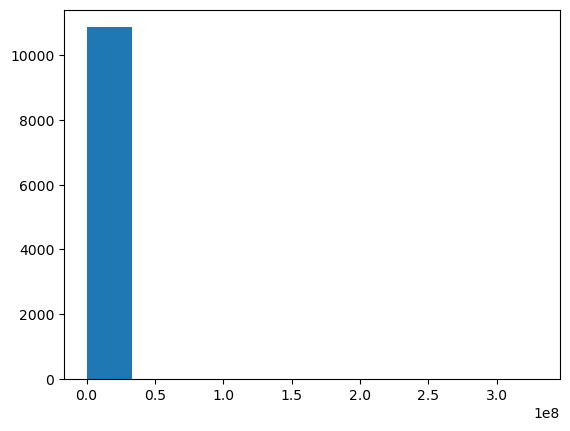

In [9]:
plt.hist((em_dat_raw["Numb_Affected"].dropna()))

In [10]:
#Range of Numb_Affected
range_Numb_Affected = em_dat_raw.sort_values(by = "Numb_Affected").dropna(subset = ["Numb_Affected"])["Numb_Affected"].max() -em_dat_raw.sort_values(by = "Numb_Affected").dropna(subset = ["Numb_Affected"])["Numb_Affected"].min()

In [11]:
em_dat_raw["Numb_Affected"].dropna().max()

330000000.0

In [12]:
#Laos datasets

em_dat_laos_raw = em_dat_raw.rename(columns=EM_DAT_COL_DICT
                 ).query("Total_Affected >1000 & Start_Year > 1970 & ISO == 'LAO' & `Disaster Type` in @DISASTERS_FOUND ")

intensity_laos_df = em_dat_laos_raw[INTENSITY_COLS].set_index(["ISO", "Start_Year"]).sort_index()

probability_laos_df = (em_dat_laos_raw.groupby(["Disaster Type", "ISO", "Start_Year", "Region"])
                        .size()
                        .unstack("Disaster Type")
                        .fillna(0)
                        .reset_index()
                        .set_index(["ISO", "Start_Year"])
                        .sort_index())

In the 33 registered disasters, there are only disasters of three types: **Drought, Flood, Storm.**

# 3. Descriptive stats for Laos

In [13]:
#Descriptive statistics Intensity
descriptive_stats_function(df = intensity_laos_df, varlist= intensity_laos_df.describe().columns.values.tolist())

,Deaths,Injured,Numb_Affected,Homeless,Total_Affected,Total_Damage,Total_Damage_Adjusted
count,20.000000,4.000000,3.200000e+01,2.000000,3.300000e+01,10.000000,10.000000
mean,20.850000,68.000000,3.317414e+05,507500.000000,3.524544e+05,46105.000000,59777.000000
std,28.961454,45.173739,6.113195e+05,696500.179469,6.126453e+05,72113.858469,89280.348569
min,1.000000,2.000000,2.000000e+03,15000.000000,2.000000e+03,50.000000,63.000000
25%,5.750000,58.250000,4.648750e+04,261250.000000,4.780000e+04,400.000000,1571.000000
50%,14.500000,84.000000,1.950000e+05,507500.000000,2.000000e+05,6825.000000,10391.000000
75%,23.000000,93.750000,4.225000e+05,753750.000000,4.300000e+05,60750.000000,79459.000000
max,136.000000,102.000000,3.500000e+06,1000000.000000,3.500000e+06,225000.000000,273023.000000
kurtosis,14.587108,2.987263,2.497072e+01,NaN,2.305156e+01,4.176681,3.128777
skewness,3.594094,-1.701630,4.754337e+00,NaN,4.502191e+00,1.992835,1.797345


In [14]:
#Descriptive statistics Probability
descriptive_stats_function(df = probability_laos_df, varlist= probability_laos_df.describe().columns.values.tolist())

,Drought,Flood,Storm
count,26.000000,26.000000,26.000000
mean,0.115385,0.846154,0.307692
std,0.325813,0.612686,0.549125
min,0.000000,0.000000,0.000000
25%,0.000000,0.250000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.750000
max,1.000000,2.000000,2.000000
kurtosis,4.914934,-0.178482,2.058359
skewness,2.557708,0.080270,1.644545


## 3.1 Event intensity through time

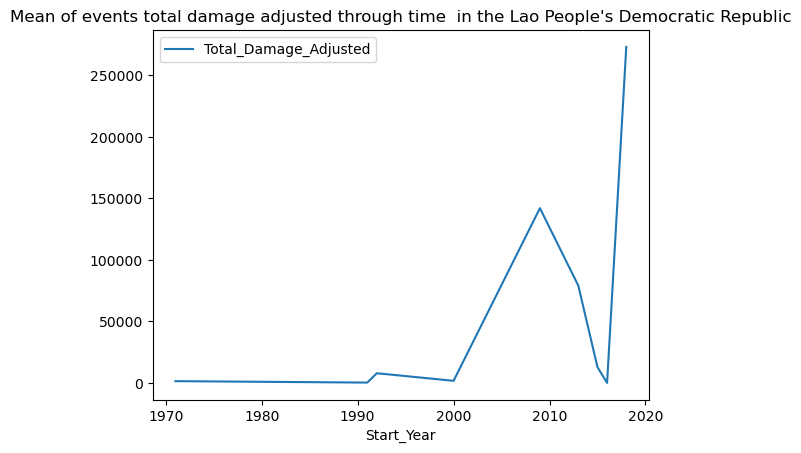

In [15]:
intensity_laos_df.pivot_table(values= "Total_Damage_Adjusted",  index = "Start_Year", 
                                  aggfunc= "mean").plot(title = "Mean of events total damage adjusted through time  in the Lao People's Democratic Republic" );


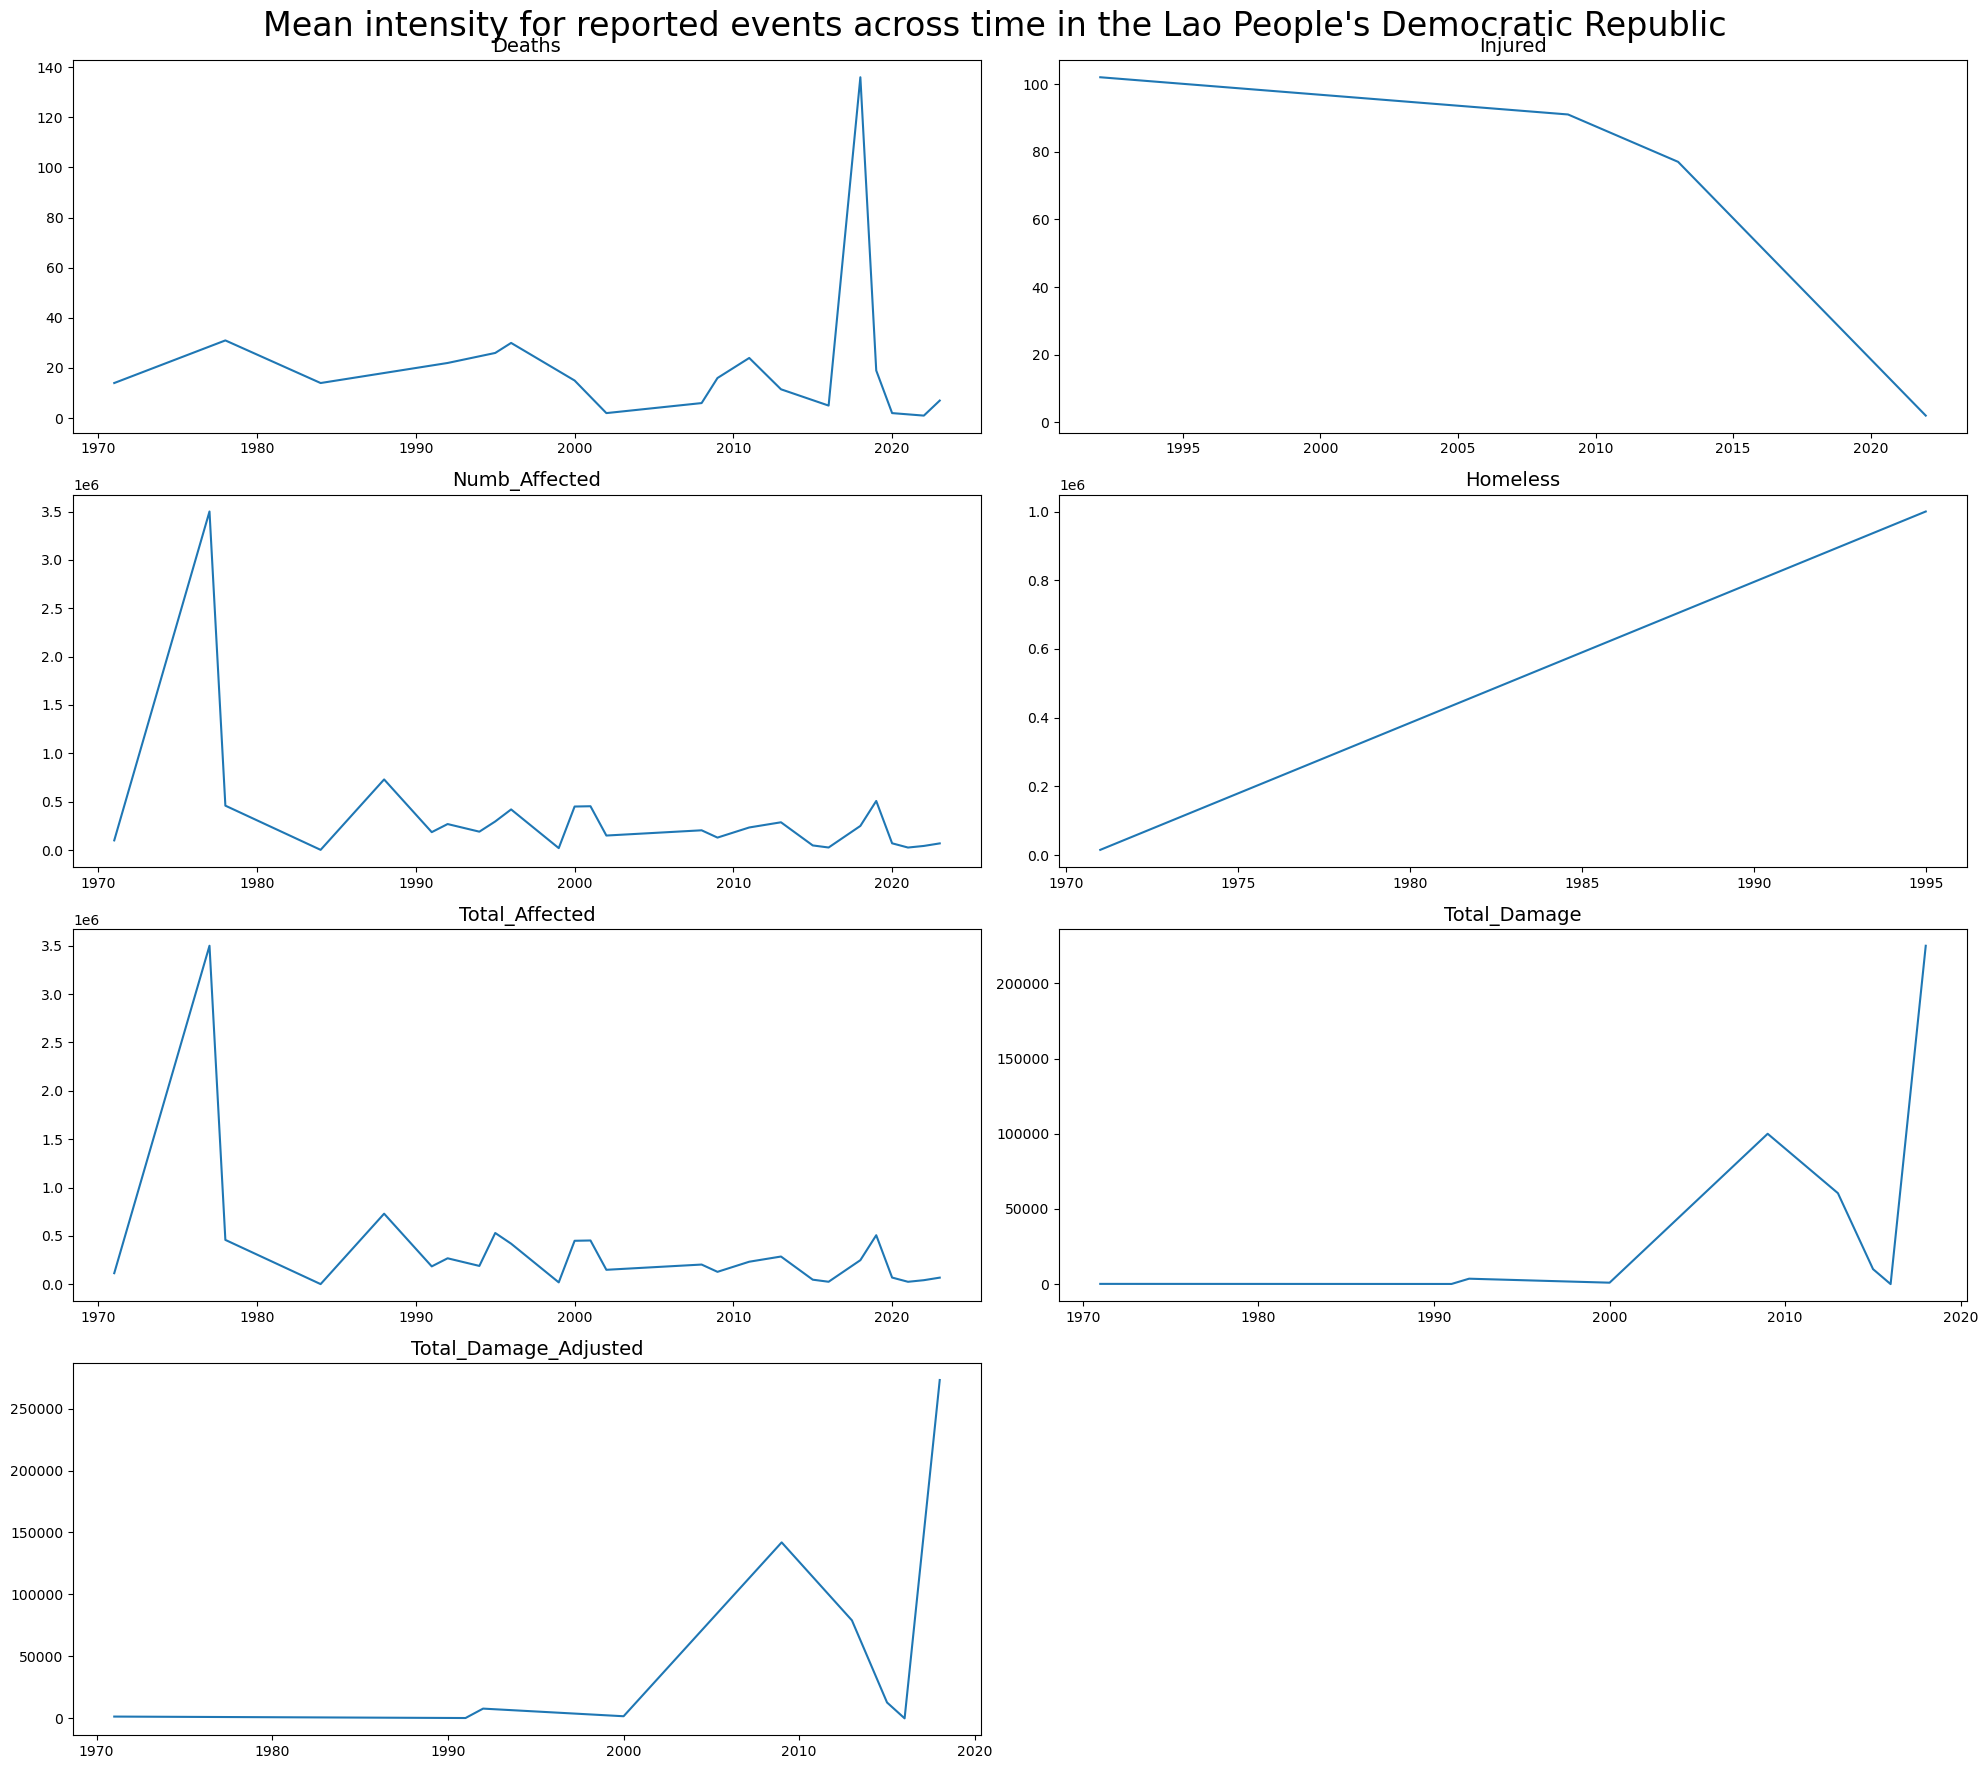

In [16]:
subplots_function( df = intensity_laos_df, var_list = intensity_laos_df.describe().columns.values.tolist(), 
                  index = "Start_Year", aggregation_funct = "mean", graph_rows =4, 
                  figure_size=  (20, 18) ,subplot_title_fontsize= 14, title = "Mean intensity for reported events across time in the Lao People's Democratic Republic")

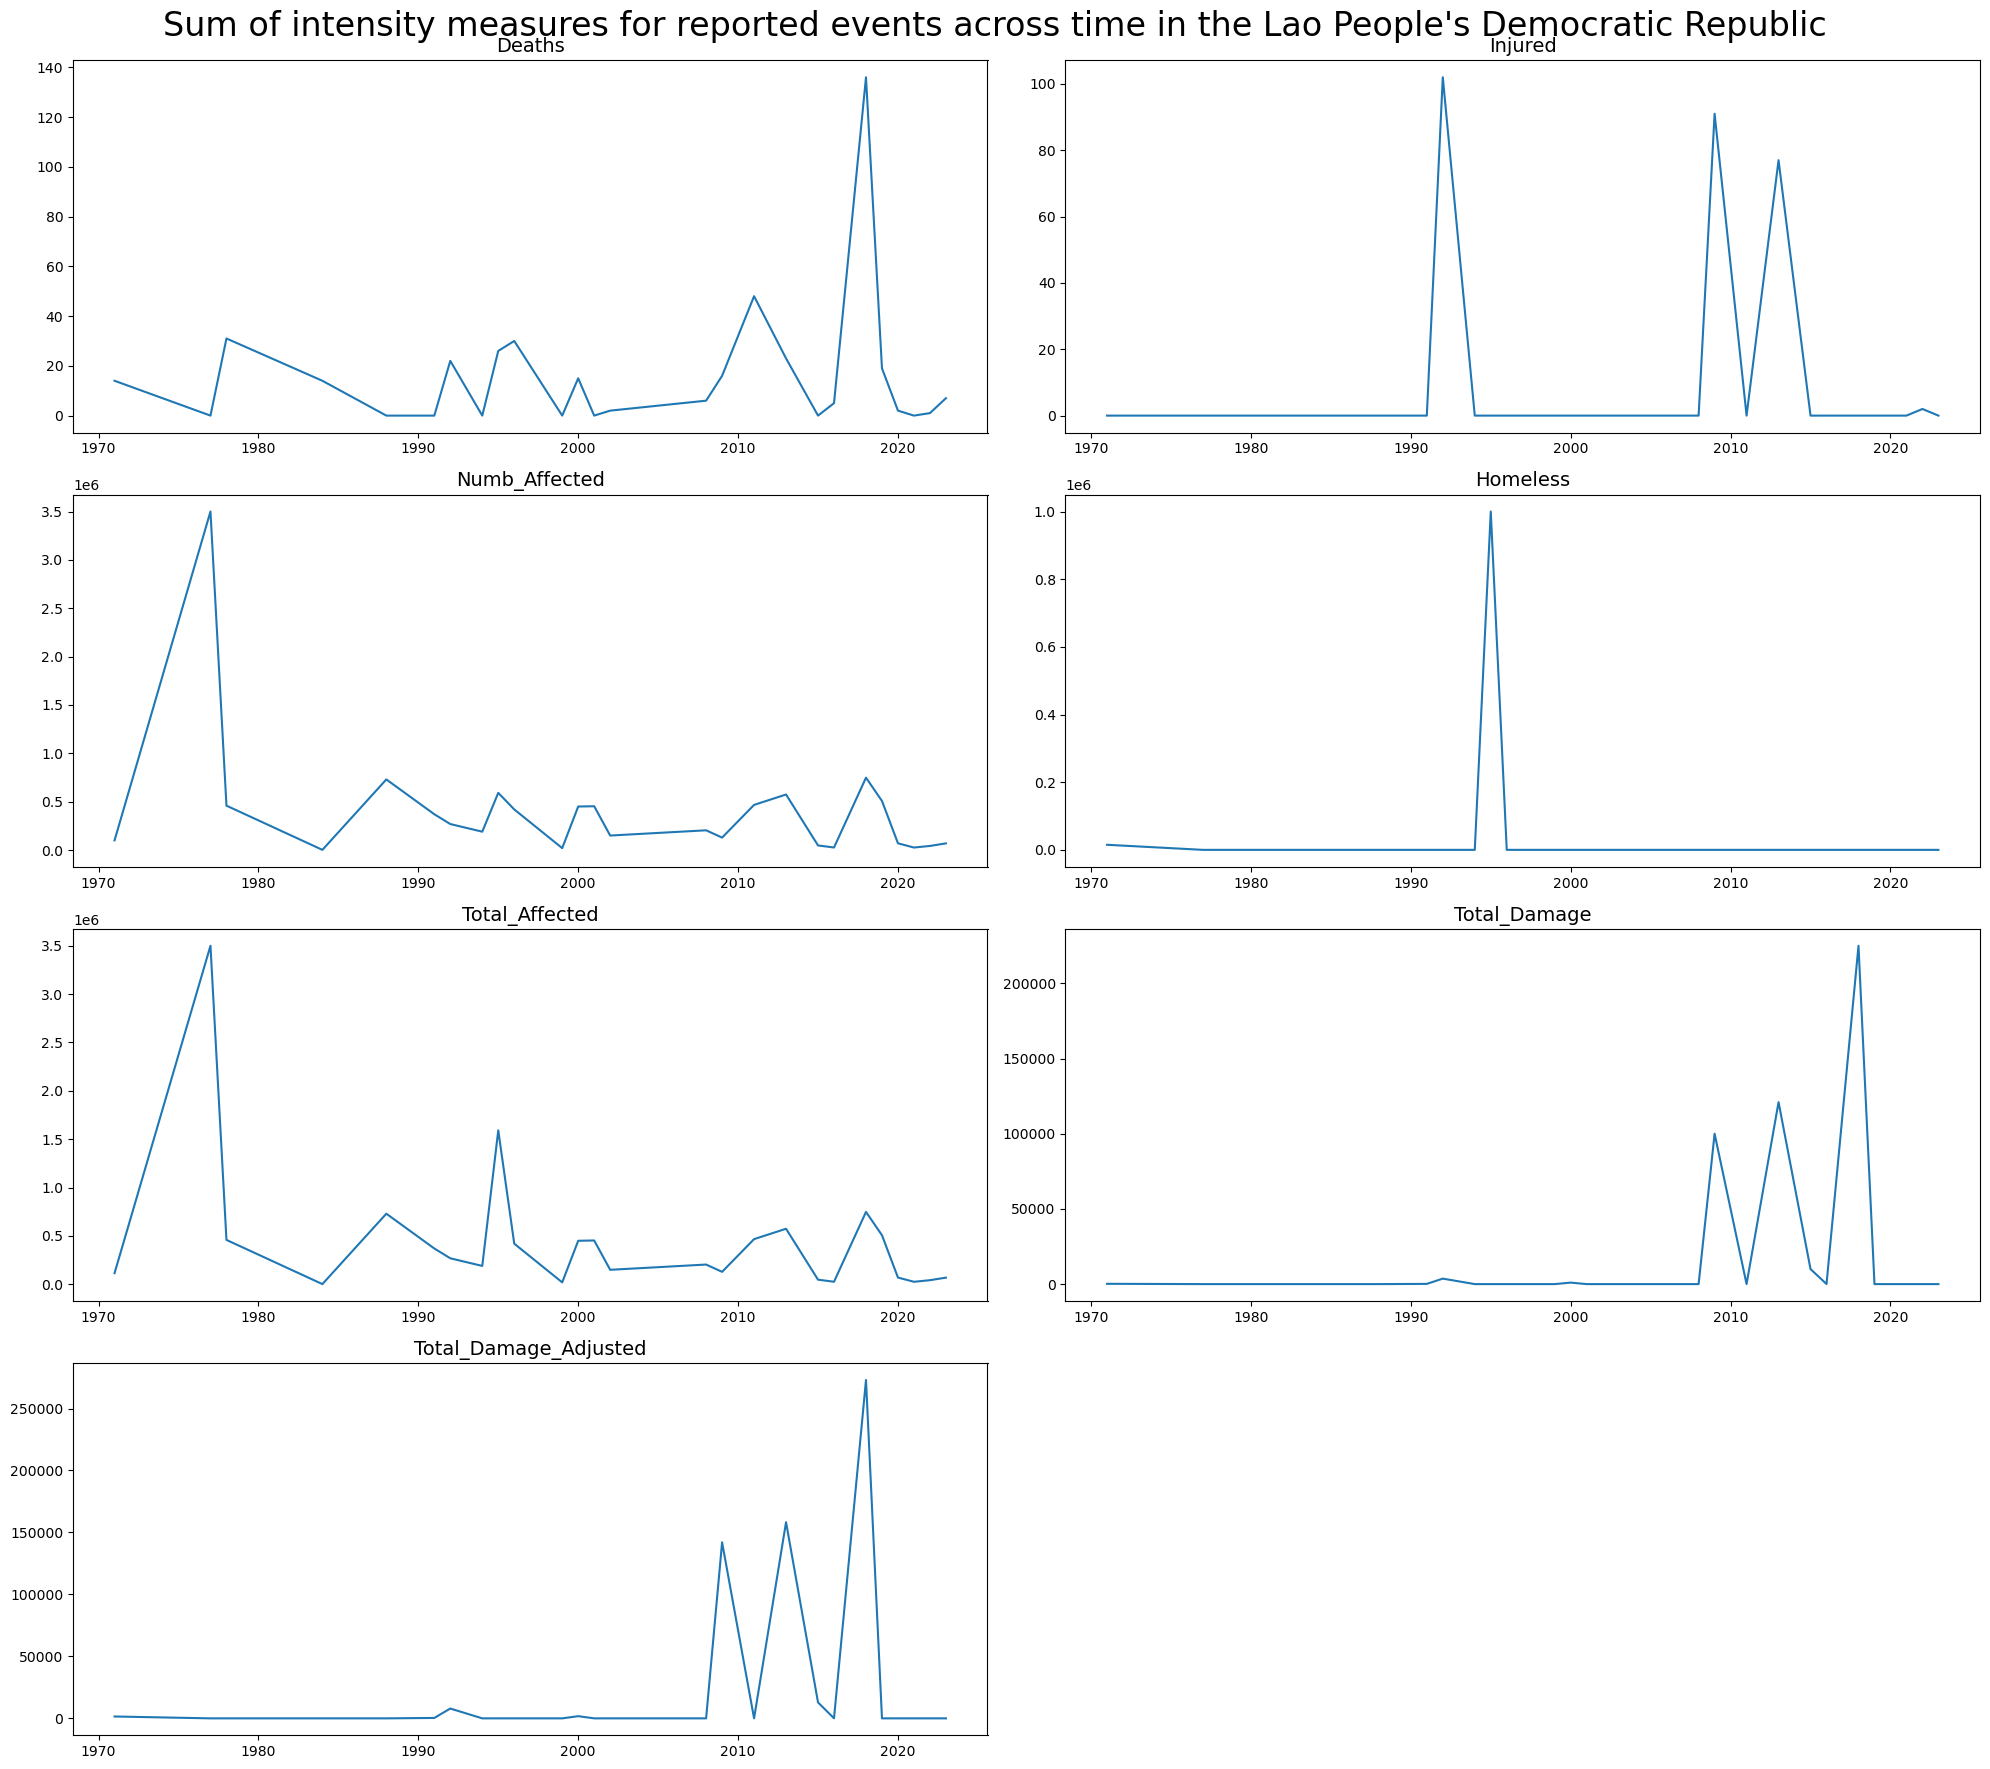

In [17]:
subplots_function( df = intensity_laos_df, var_list = intensity_laos_df.describe().columns.values.tolist(), 
                  index = "Start_Year", aggregation_funct = "sum", graph_rows =4, 
                  figure_size=  (20, 18) ,subplot_title_fontsize= 14, title = "Sum of intensity measures for reported events across time in the Lao People's Democratic Republic")

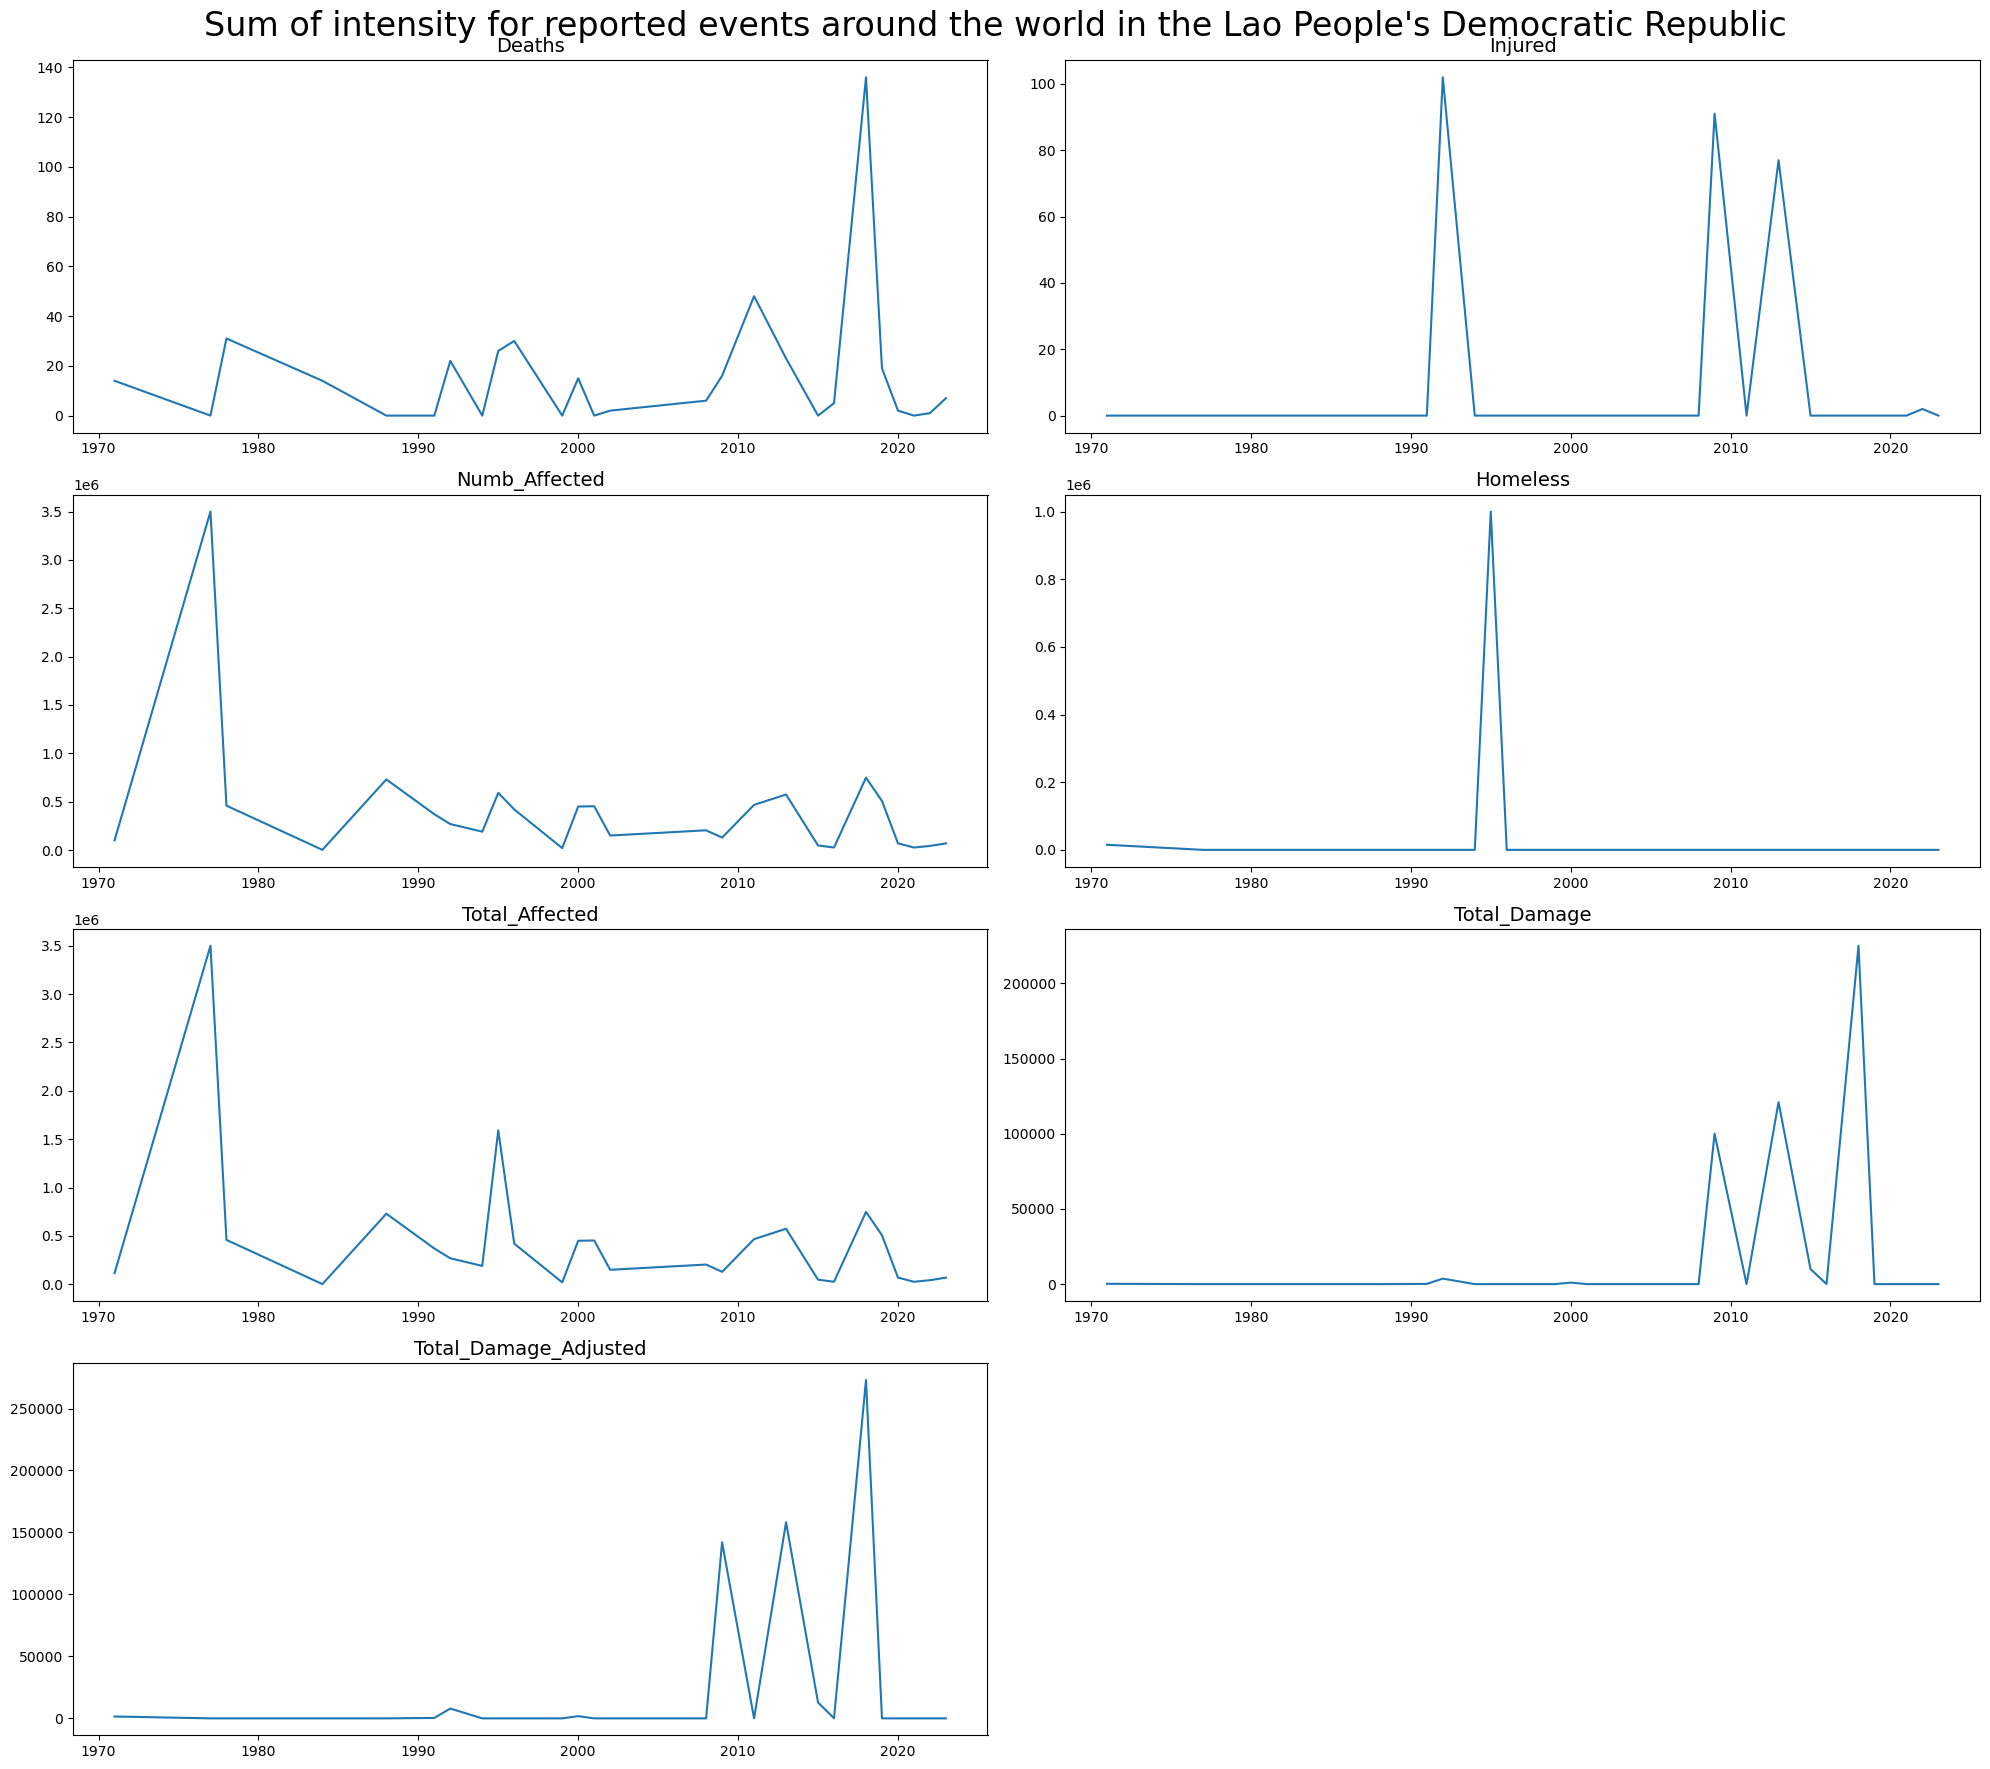

In [18]:
subplots_function( df = intensity_laos_df, var_list = intensity_laos_df.describe().columns.values.tolist(), 
                  index = "Start_Year", aggregation_funct = "sum", graph_rows =4, 
                  figure_size=  (20, 18) ,subplot_title_fontsize= 14, title = "Sum of intensity for reported events around the world in the Lao People's Democratic Republic")

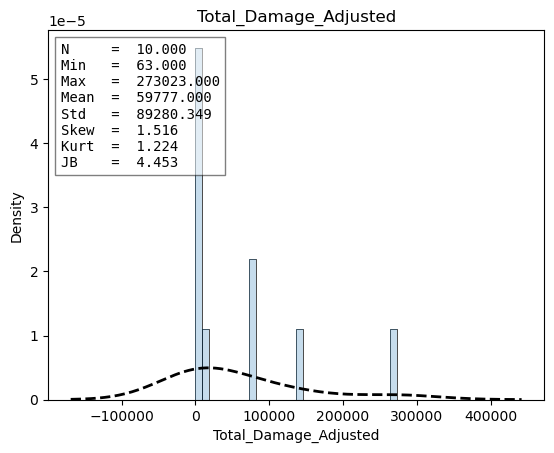

In [19]:
#Histogram and Kernel density for  total damage adjusted
_plot_single_kde(data =intensity_laos_df["Total_Damage_Adjusted"]);

## 3.2 Number of events through time

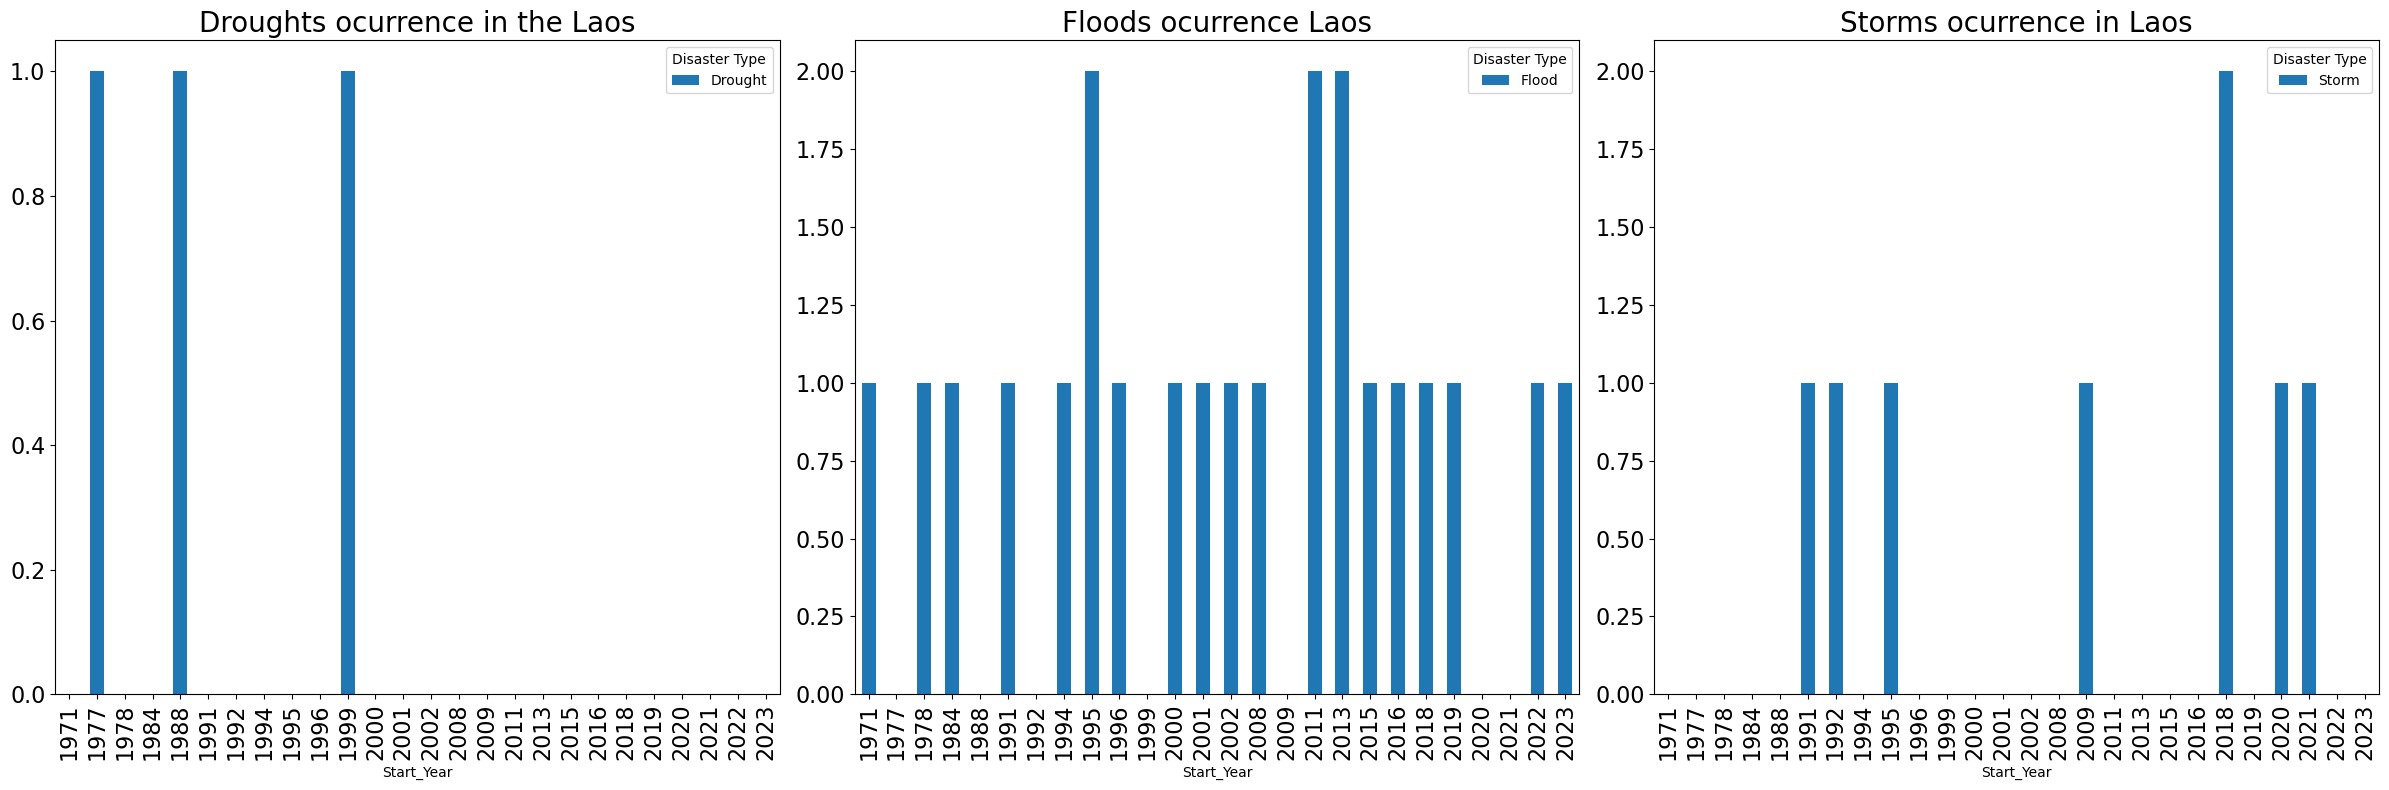

In [20]:
fig, axes = plt.subplots(figsize=(24,8),nrows=1, ncols=3)


probability_laos_df.pivot_table( values= "Drought",  index = "Start_Year", 
                                  aggfunc= "sum").plot(ax=axes[0], kind = "bar");
axes[0].set_title(label = "Droughts ocurrence in the Laos", fontsize= 20)
axes[0].tick_params(axis='both',  labelsize= 16)

probability_laos_df.pivot_table( values= "Flood",  index = "Start_Year", 
                                  aggfunc= "sum").plot(ax=axes[1], kind = "bar");
axes[1].tick_params(axis='both',  labelsize= 16)
axes[1].set_title(label = "Floods ocurrence Laos", fontsize= 20 )

probability_laos_df.pivot_table( values= "Storm",  index = "Start_Year", 
                                  aggfunc= "sum").plot(ax=axes[2], kind = "bar")

axes[2].set_title(label = "Storms ocurrence in Laos", fontsize= 20)
axes[2].tick_params(axis='both',  labelsize= 16);

plt.tight_layout()